In [1]:
import cupy as cp
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

---

# Task 10. Saxpy
By using `CuPy`, implement `SAXPY` function. The function is described in the picture.

### 10.1 
**Q1 Difference between CuPy and NumPy**

NumPy is designed to run on CPU so the parallelization capabilities are limited by the number of available CPU cores. CuPy is the implementation of Numpy adapted to be run on GPU through the CUDA library. Therefore, the usage of CuPy allows achieving a superior speed-up utilizing GPU resources.

**Q2 How does CuPy handles data transfer between CPU and GPU**

CuPy uses memory pool for memory allocations by default. For the purposes of CPU-to-GPU data transfer CuPy used pinned memory pool (non-swappable CPU memory). The memory pool significantly improves the performance by mitigating the overhead of memory allocation and CPU/GPU synchronization.



### 10.2 SAXPY implementation

In [2]:
def saxpy(x: cp.array, y: cp.array, a: float) -> cp.array:
    assert x.shape[0] == y.shape[0], 'x and y should be the same lenth!'
    return a * x + y

### 10.3 NumPy vs CuPy profiling

In [3]:
alpha : float = 3.9
n_points : int = 5
exe_time_cp, exe_time_np, arr_size = np.zeros(n_points), np.zeros(n_points), np.zeros(n_points)
for n in range(n_points):
    size : int = 10 ** (n + 3)
    arr_cp, arr_np  = cp.random.random(size), np.random.random(size)
    
    res_cp  = %timeit -n 100 -o saxpy(arr_cp, arr_cp, alpha)
    res_np = %timeit -n 100 -o saxpy(arr_np, arr_np, alpha)
    
    exe_time_cp[n], exe_time_np[n], arr_size[n]  = res_cp.average, res_np.average, arr_np.nbytes / 1e6

The slowest run took 131.83 times longer than the fastest. This could mean that an intermediate result is being cached.
863 µs ± 2 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
5.36 µs ± 2.68 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
43.9 µs ± 1.24 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
17.1 µs ± 1.58 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
44.8 µs ± 1.99 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
164 µs ± 9.86 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
45.8 µs ± 2.12 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.49 ms ± 12 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
The slowest run took 17.14 times longer than the fastest. This could mean that an intermediate result is being cached.
199 µs ± 255 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
49.9 ms ± 612 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


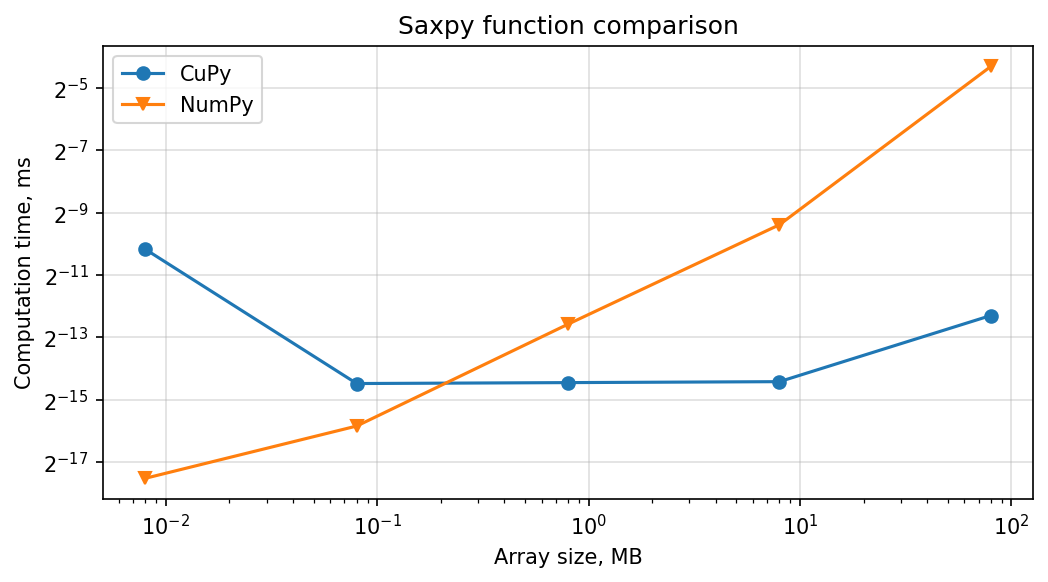

In [4]:
fig, ax = plt.subplots(figsize=(8,4), dpi=150)
ax.plot(arr_size, exe_time_cp, '-o', label='CuPy')
ax.plot(arr_size, exe_time_np, '-v', label='NumPy')
ax.grid(alpha=.4)
ax.set_xscale('log',base=10)
ax.set_yscale('log',base=2)
ax.set_xlabel('Array size, MB')
ax.set_ylabel('Computation time, ms')
plt.legend()
plt.title('Saxpy function comparison')
plt.show()

---

# Task 11. CuPy-based Bifurcation map

By using **CuPy**, reimplement bifurcation map (Task 1).

### 11.1 CuPy & NumPy implementation (single function)

In [5]:
r_start, r_stop = 2.5, 4.0

def log_map(r: cp.array, x: cp.array)-> float:
    return r * x * (1 - x)

def bifurcation_rx(n : int=10000, iterations : int =500, cupy : bool=False) -> list:
    if cupy:
        r, x = cp.linspace(r_start, r_stop, n), cp.linspace(0, 1, n) # CuPy arrays
    else:
        r, x = np.linspace(r_start, r_stop, n), np.linspace(0, 1, n) # NumPy arrays
    rx_values = []
    for i in range(iterations):
        x = log_map(r, x)
        if i >= (iterations - 100): # Treashlod
            rx_values.append((r, x))
    return rx_values

def plot_bifurcation(rx_values: list) -> None:
    fig, ax1 = plt.subplots(figsize=(16, 8), dpi=200)
    for r, x in rx_values:
        ax1.plot(r, x, ',') # Use a small marker to faster rende
        ax1.set_ylim(0, 1)
    ax1.set_xlim(r_start, r_stop)
    ax1.set_title("Bifurcation diagram")
    ax1.set_xlabel('$r$', fontsize=16)
    ax1.set_ylabel('$X_t$', fontsize=16)
    plt.grid(alpha=.4)
    plt.show()

### 11.2 Bifurcation profiling

In [6]:
bifurcation_rx(cupy = True);

In [7]:
!nvidia-smi

Thu Dec 23 11:27:13 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.04   Driver Version: 450.119.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    36W / 250W |    569MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### 11.3 NumPy vs CuPy comparison

In [8]:
n_points : int = 4
exe_time_cp, exe_time_np, n_iterations = np.zeros(n_points), np.zeros(n_points), np.zeros(n_points)
for n in range(n_points):
    n_iter : int = 10 ** (n + 3)
        
    res_cp  = %timeit -n 10 -o bifurcation_rx(n_iter, cupy=True)
    res_np = %timeit -n 10 -o bifurcation_rx(n_iter)
    
    exe_time_cp[n], exe_time_np[n], n_iterations[n]  = res_cp.average, res_np.average, n_iter

32.2 ms ± 610 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
3.93 ms ± 1.17 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
32.3 ms ± 505 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
17.1 ms ± 2.58 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
36.9 ms ± 7.21 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
168 ms ± 7.89 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
61.4 ms ± 1.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
1.57 s ± 26.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


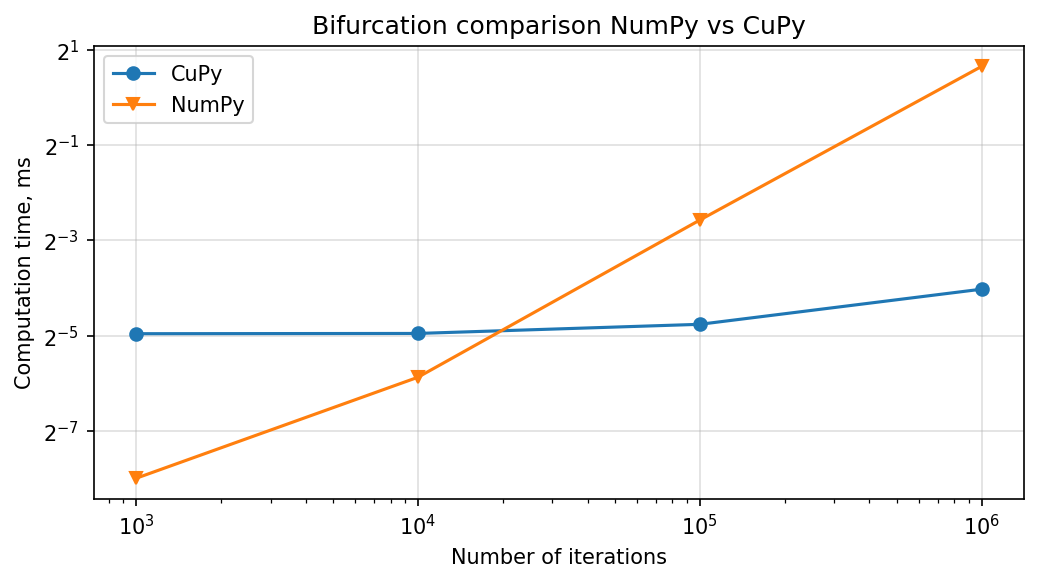

In [9]:
fig, ax = plt.subplots(figsize=(8,4), dpi=150)
ax.plot(n_iterations, exe_time_cp, '-o', label='CuPy')
ax.plot(n_iterations, exe_time_np, '-v', label='NumPy')
ax.grid(alpha=.4)
ax.set_xscale('log',base=10)
ax.set_yscale('log',base=2)
ax.set_xlabel('Number of iterations')
ax.set_ylabel('Computation time, ms')
plt.legend()
plt.title('Bifurcation comparison NumPy vs CuPy')
plt.show()

---

# Task 12. Histogram


<u>By using <i><strong>CuPy</strong></i>:</u>
* Implement the suggested function:
$$
 f(x) = (z^2(x) + z^3(x) - 200 \,\, z^4(x) )\,\,\sin(\,\,100000\,\,(x + 0.5)\,\,),
 \\
 \text{where    }\:\:\: z(x) = \sin(3\,\,x)-0.5
$$
* Plot function on the $x$ interval $[0,\,\, 1]$. Number of points = 10000000.
* Get minimal and maximal values of function on the interval $[0,\,\, 1]$: $f_{min}$ and $f_{max}$.
* Divide $y=f(x), \: (x \in [0,\,\, 1]) \:$ interval $[f_{min}, f_{max}]$ into $10$ $y=f(x)$ subintervals of length $\delta$ equal to $0.1 \,\, (f_{max}-f_{min})$: $[f_{min},\,\, f_{min} + \delta],\,\, [f_{min}+ \delta,\,\, f_{min} + 2 \,\, \delta],\,\, \dots,\,\, [f_{max}- \delta,\,\, f_{max}]$.
* Compute number of $y=f(x), \: (x \in [0,\,\, 1]) \:$ values in each subinterval. Use $\operatorname{cp.sum(\dots)}$
* Plot histogram.

In [10]:
n_points : int = 10000000
n_intervals : int  = 10

def calculate_hist(n_points : int = 10000000, n_intervals : int = 10, cupy: bool = False) -> tuple:
    kernel = cp if cupy else np

    def f(x: kernel.array) -> kernel.array:
        z = lambda x : kernel.sin(3 * x) - 0.5
        return (z(x) ** 2 + z(x) ** 3 - 200 * z(x) ** 4) * kernel.sin(100000 * (x + 0.5))

    x_val = kernel.linspace(0, 1, n_points)
    f_val = f(x_val) # y = f(x)

    f_left, f_right = kernel.min(f_val), kernel.max(f_val)
    delta = kernel.abs(f_left - f_right) * 0.1
    
    intervals = kernel.arange(kernel.float_(f_left), kernel.float_(f_right + delta), kernel.float_(delta))

    borders = ((intervals[i], intervals[i + 1])  for i in range(n_intervals))
    hist = kernel.array([kernel.sum((left <= f_val) & (f_val<= right)) for i, (left, right) in enumerate(borders)])
    
    return hist, intervals, f_val

### 12.1 Plotting $f(x)$

In [11]:
hist, intervals, f_val = calculate_hist(n_points)

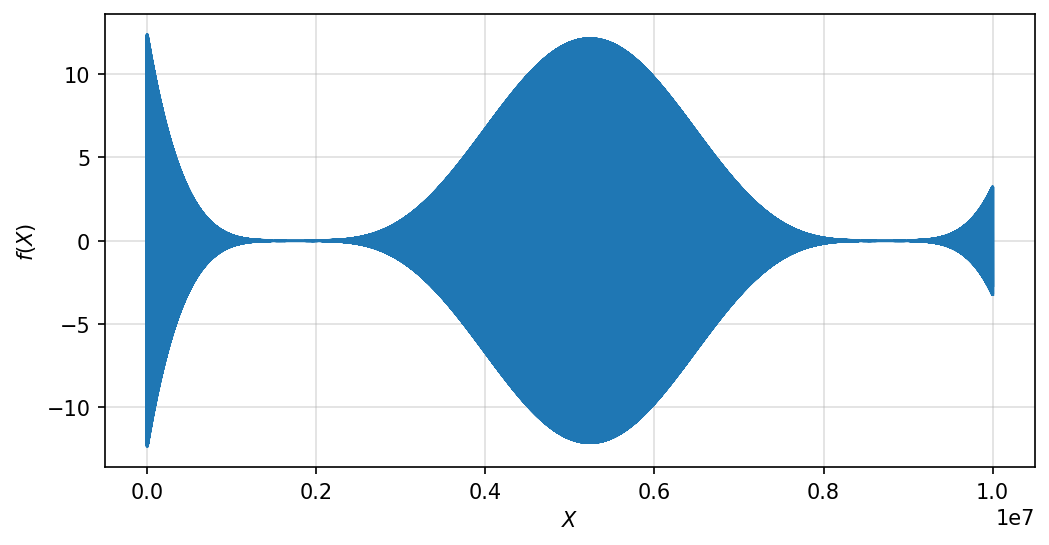

In [12]:
fig, ax = plt.subplots(figsize=(8, 4), dpi=150)
ax.plot(f_val)
ax.set_xlabel('$X$')
ax.set_ylabel('$f(X)$')
ax.grid(alpha=.4)
plt.show()

### 12.2 Histogram plot

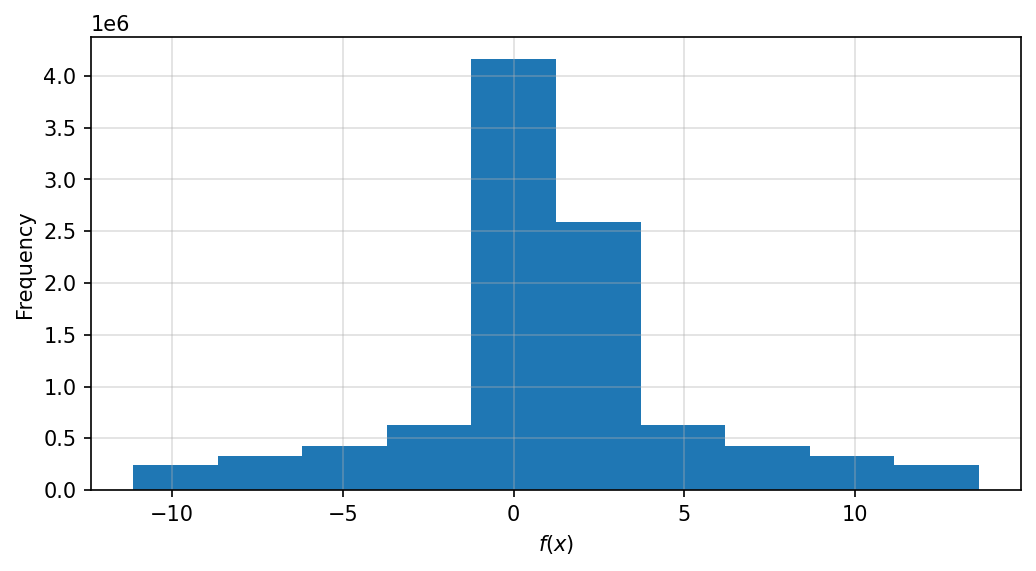

In [13]:
fig, ax = plt.subplots(figsize=(8,4), dpi=150)
ax.bar(x=intervals[1:],height=hist, width=2.5)
ax.set_xlabel('$f(x)$')
ax.set_ylabel('Frequency')
ax.grid(alpha=.4)
plt.show()

### 12.3 NumPy vs CuPy implimentations comparison for different number of points

In [14]:
n_points : int = 5
exe_time_cp, exe_time_np, n_iterations = np.zeros(n_points), np.zeros(n_points), np.zeros(n_points)
for n in range(n_points):
    n_iter : int = 10 ** (n + 3)
        
    res_cp  = %timeit -n 10 -o calculate_hist(n_iter, cupy=True)
    res_np = %timeit -n 10 -o calculate_hist(n_iter)
    
    exe_time_cp[n], exe_time_np[n], n_iterations[n]  = res_cp.average, res_np.average, n_iter

The slowest run took 254.12 times longer than the fastest. This could mean that an intermediate result is being cached.
85.3 ms ± 203 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
448 µs ± 32.7 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
2.36 ms ± 50 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
1.8 ms ± 104 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
2.4 ms ± 33.8 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
13.8 ms ± 206 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
7.97 ms ± 66.9 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
148 ms ± 5.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
113 ms ± 2.42 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
1.84 s ± 22.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


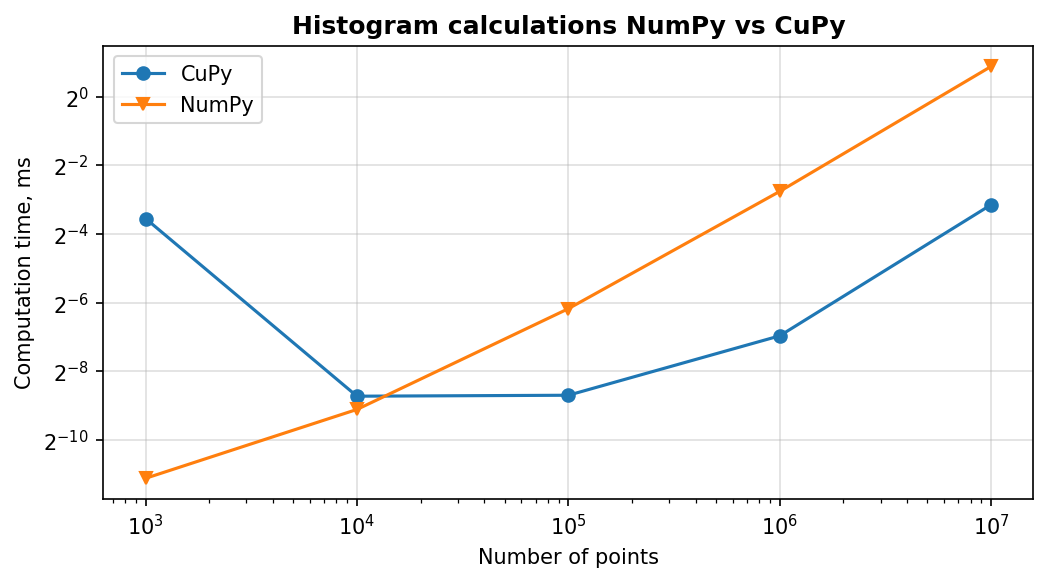

In [15]:
fig, ax = plt.subplots(figsize=(8,4), dpi=150)
ax.plot(n_iterations, exe_time_cp, '-o', label='CuPy')
ax.plot(n_iterations, exe_time_np, '-v', label='NumPy')
ax.grid(alpha=.4)
ax.set_xscale('log',base=10)
ax.set_yscale('log',base=2)
ax.set_xlabel('Number of points')
ax.set_ylabel('Computation time, ms')
plt.legend()
plt.title('Histogram calculations NumPy vs CuPy', fontweight='bold')
plt.show()

---

# Task 13. Image blur


<u>By using <i><strong>CuPy</strong></i>:</u>
* Implement the GPU version of the image blur algorithm. What you need to do is calculate convolution some image and some blur filter on every pixel. You should compute convolutions in parallel for every pixel using gpu cores.
* Take any 100x100 image 


In [16]:
from skimage.io import imshow, imread

In [17]:
def bluring_image_benchmark(img, cupy=False):
    kernel = cp if cupy else np
    def avg_pixel(matrix: kernel.ndarray, i: int, j: int) -> kernel.ndarray:
        """
        Get average pixel color from 8 nearest neighbours without boundary conditions
        """
        return kernel.average(matrix[i - 1 : i + 2, j - 1 : j + 2])

    def one_pixel_blur(previous_gen: kernel.ndarray) -> kernel.ndarray:
        n, m = previous_gen.shape
        next_gen = kernel.zeros((n, m))
        for i in range(n):
            for j in range(m):
                next_gen[i, j] = avg_pixel(previous_gen, i, j)
        return next_gen

    def image_blur(img: kernel.ndarray) -> kernel.ndarray:
        if kernel == cp:
            img = cp.asarray(img) # transit to CuPy array
            r, g, b = img[:,:,0], img[:,:,1], img[:,:,2]
        else:
            r, g, b = img[:,:,0], img[:,:,1], img[:,:,2] # use NumPy arrays
        
        blur_r, blur_g, blur_b = one_pixel_blur(r), one_pixel_blur(g), one_pixel_blur(b)

        blur_r[:,0], blur_r[0] = r[:,0], r[0]
        blur_g[:,0], blur_g[0] = g[:,0], g[0]
        blur_b[:,0], blur_b[0] = b[:,0], b[0]

        return kernel.ceil(kernel.stack((blur_r, blur_g, blur_b), 2)).astype('int')
    return image_blur(img)

### 13.1 Image bluring on GPU

In [18]:
cat_img = imread('../input/cat-blur/ca7.jpg')

blured_img = bluring_image_benchmark(cat_img, cupy=True)

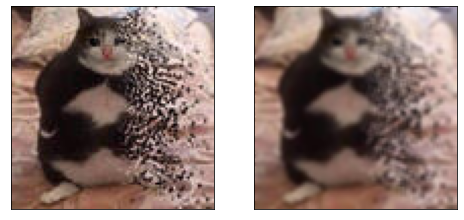

In [19]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(8,8))
ax0.imshow(cat_img)
ax1.imshow(cp.asnumpy(blured_img))
ax0.axes.get_xaxis().set_visible(False)
ax1.axes.get_xaxis().set_visible(False)

ax0.axes.get_yaxis().set_visible(False)
ax1.axes.get_yaxis().set_visible(False)
plt.show()

### 13.2 & 13.3 Measuring NumPy vs CuPy computation time

In [20]:
%timeit -n 10 -o bluring_image_benchmark(cat_img, cupy=True) # CuPy implementation
%timeit -n 10 -o bluring_image_benchmark(cat_img) # NumPy implementation

3.28 s ± 26.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
513 ms ± 27.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


<TimeitResult : 513 ms ± 27.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)>

---